## Here we train the model sequentially on datasets 1, 2, 3

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [3]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [4]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [5]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [6]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [7]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length]) # Target is a single step

    return np.array(sequences), np.array(targets)


In [8]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[:int(n*0.8)]
val_df1 = first_piece[int(n*0.8):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device='cuda') # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1).to(device='cuda')  # (batch, output_dim)

# Data piece 2

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.8)]
val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 12)
val_seq2, val_labels2 = create_sequences(val_df2.values, 12)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device='cuda') # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2).to(device='cuda')  # (batch, output_dim)

# Data piece 3

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 =third_piece[0:int(n*0.8)]
val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 12)
val_seq3, val_labels3 = create_sequences(val_df3.values, 12)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device='cuda') # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3).to(device='cuda')  # (batch, output_dim)

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        out = self.fc(out[:, -1, :])  # Take the last 30 time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

In [10]:
model123 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model123 = model123.to("cuda")  # Use "cuda" if you have a GPU

# model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model2 = model2.to("cuda")  # Use "cuda" if you have a GPU

# model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model3 = model3.to("cuda")  # Use "cuda" if you have a GPU

criterion123 = nn.SmoothL1Loss()
optimizer123 = optim.Adam(model123.parameters(), lr=1e-4)

### Train on partitions 1, 2, 3

In [11]:
num_epochs = 200

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model123.train()
    optimizer123.zero_grad()
    y_pred = model123(train_seq_tensor1)
    loss = criterion123(y_pred, train_label_tensor1)
    train_losses.append(loss.item())

    loss.backward()
    optimizer123.step()

    # Validation
    model123.eval()
    with torch.no_grad():
        y_val = model123(val_seq_tensor1)
    val_loss = criterion123(y_val, val_label_tensor1)
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}. Train loss: {loss.item()}. Val loss: {val_loss.item()}')

Epoch: 0. Train loss: 0.4390714764595032. Val loss: 1.3101705312728882
Epoch: 10. Train loss: 0.42971622943878174. Val loss: 1.2652676105499268
Epoch: 20. Train loss: 0.41102325916290283. Val loss: 1.1865646839141846
Epoch: 30. Train loss: 0.35569196939468384. Val loss: 0.9375706911087036
Epoch: 40. Train loss: 0.20318956673145294. Val loss: 0.12101206928491592
Epoch: 50. Train loss: 0.17503537237644196. Val loss: 0.0533197820186615
Epoch: 60. Train loss: 0.15224167704582214. Val loss: 0.01538305263966322
Epoch: 70. Train loss: 0.1461547315120697. Val loss: 0.018808983266353607
Epoch: 80. Train loss: 0.13754692673683167. Val loss: 0.033853933215141296
Epoch: 90. Train loss: 0.12864547967910767. Val loss: 0.010907240211963654
Epoch: 100. Train loss: 0.11929771304130554. Val loss: 0.01512918807566166
Epoch: 110. Train loss: 0.10824048519134521. Val loss: 0.018864205107092857
Epoch: 120. Train loss: 0.09498816728591919. Val loss: 0.01977498270571232
Epoch: 130. Train loss: 0.0781241357326

In [12]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model123.train()
    optimizer123.zero_grad()
    y_pred = model123(train_seq_tensor2)
    loss = criterion123(y_pred, train_label_tensor2)
    train_losses.append(loss.item())
    
    loss.backward()
    optimizer123.step()

    # Validation
    model123.eval()
    with torch.no_grad():
        y_val = model123(val_seq_tensor2)

    val_loss = criterion123(y_val, val_label_tensor2)
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}. Train loss: {loss.item()}. Val loss: {val_loss.item()}')

Epoch: 0. Train loss: 0.03527127206325531. Val loss: 0.014681847766041756
Epoch: 10. Train loss: 0.02708379179239273. Val loss: 0.02992655336856842
Epoch: 20. Train loss: 0.024739950895309448. Val loss: 0.03752549737691879
Epoch: 30. Train loss: 0.02315625548362732. Val loss: 0.03192785382270813
Epoch: 40. Train loss: 0.02174772508442402. Val loss: 0.03487372398376465
Epoch: 50. Train loss: 0.020599117502570152. Val loss: 0.03336295485496521
Epoch: 60. Train loss: 0.019464842975139618. Val loss: 0.02870461717247963
Epoch: 70. Train loss: 0.01827722229063511. Val loss: 0.026376008987426758
Epoch: 80. Train loss: 0.01705760322511196. Val loss: 0.02483266592025757
Epoch: 90. Train loss: 0.015853388234972954. Val loss: 0.02305768057703972
Epoch: 100. Train loss: 0.014822619967162609. Val loss: 0.022811654955148697
Epoch: 110. Train loss: 0.014099109917879105. Val loss: 0.02228819578886032
Epoch: 120. Train loss: 0.013587492518126965. Val loss: 0.020112227648496628
Epoch: 130. Train loss: 0

In [13]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model123.train()
    optimizer123.zero_grad()
    y_pred = model123(train_seq_tensor3)
    loss = criterion123(y_pred, train_label_tensor3)
    train_losses.append(loss.item())
    
    loss.backward()
    optimizer123.step()

    # Validation
    model123.eval()
    with torch.no_grad():
        y_val = model123(val_seq_tensor3)

    val_loss = criterion123(y_val, val_label_tensor3)
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}. Train loss: {loss.item()}. Val loss: {val_loss.item()}')

Epoch: 0. Train loss: 0.018846921622753143. Val loss: 0.007459136191755533
Epoch: 10. Train loss: 0.01719716563820839. Val loss: 0.010945423506200314
Epoch: 20. Train loss: 0.016002563759684563. Val loss: 0.010071269236505032
Epoch: 30. Train loss: 0.015650270506739616. Val loss: 0.006641122978180647
Epoch: 40. Train loss: 0.013890800066292286. Val loss: 0.0069594611413776875
Epoch: 50. Train loss: 0.012876753695309162. Val loss: 0.00758996419608593
Epoch: 60. Train loss: 0.012136049568653107. Val loss: 0.00910775363445282
Epoch: 70. Train loss: 0.01139981858432293. Val loss: 0.007226485759019852
Epoch: 80. Train loss: 0.010977423749864101. Val loss: 0.008023862726986408
Epoch: 90. Train loss: 0.010566945187747478. Val loss: 0.008636296726763248
Epoch: 100. Train loss: 0.010200729593634605. Val loss: 0.007231426425278187
Epoch: 110. Train loss: 0.009835260920226574. Val loss: 0.0081824641674757
Epoch: 120. Train loss: 0.010346733964979649. Val loss: 0.008568095043301582
Epoch: 130. Tra

### Now let's predict dataset 4

In [14]:
test_data = (fourth_piece[:] - fourth_piece.mean())/fourth_piece.std() 
test_seq, test_labels = create_sequences(test_data.values, 12)

test_seq_tensor = torch.FloatTensor(test_seq).to(device='cuda')
test_label_tensor = torch.FloatTensor(test_labels).to(device='cuda')

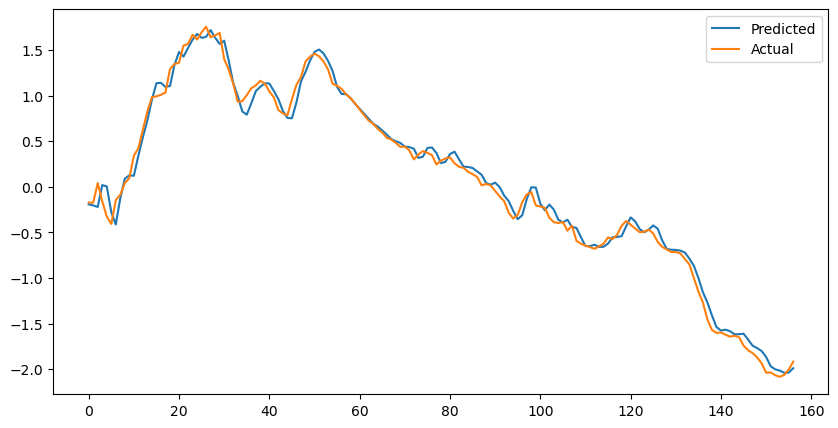

In [15]:
with torch.no_grad():
    y_pred = model123(test_seq_tensor)

plt.figure(figsize=(10,5))
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.plot(test_label_tensor.cpu().numpy(), label='Actual')
plt.legend()
plt.show()